In [12]:
%load_ext autoreload
%autoreload 2

from Recommender_Lib import *

import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# First, make sure the data we want exists. If not, download from google drive
verify_procd_data_exists()

# Now, load in all the processed data
processed_data_specs = json.load(open(PATH_TO_PROCESSED_DATA_SPECS))
movie_ids = processed_data_specs[SPEC_MOVIE_IDS]
user_ids = processed_data_specs[SPEC_USER_IDS]
movie_matrix_col_count = processed_data_specs[SPEC_MOVIES_MATRIX_COLUMN_COUNT]
num_toks_to_embed = processed_data_specs[SPEC_NUM_TOKS_EMBEDDED]
embedded_vec_len = processed_data_specs[SPEC_EMBEDDING_LEN]
total_users = len(user_ids)
total_movies = len(movie_ids)

''' 
users matrix includes user ID as part of each row, but that is just the index + 1
don't want it part of the future considerations, so just remove it.
''' 
users_matrix = np.load(PATH_TO_PROCESSED_USERS_DATA)[USERS_MATRIX][:,1:]

''' 
movies matrix includes movie ID as part of each row, but found a different way to determine
the movie ID and don't want it part of the clustering, so just remove it.
''' 
movies_data = np.load(PATH_TO_PROCESSED_MOVIES_DATA)
sparse_movies_coords = movies_data[SPARSE_COORDS_TAG]
sparse_movies_matrix = sparse.csr_matrix(
    (movies_data[SPARSE_DATA_TAG], (sparse_movies_coords[0], sparse_movies_coords[1])),
    shape=(total_movies, movie_matrix_col_count))[:,list(range(1,(movie_matrix_col_count-1)))].astype(np.float32)

In [3]:
# Read in the raw data so we have access to movie titles, genres
movies_df, users_df, _ = read_raw_data()

In [4]:
'''
To factorize RatingsMat = UserMat x MovieMat, need the UserMat to be Nxk and MovieMat to be kxM.
First, let's try doing the movies mat without the title embeddings since they less describe the movie.
Also, transpose it cuz it is currently Mxk.
This will make the MovieMat be 168xM
'''

'''
Center the data around zero, then remove the title embedding cols
'''
procd_movies_df = pd.DataFrame(sparse_movies_matrix.toarray())
standardized_procd_movies = StandardScaler().fit_transform(procd_movies_df)
non_title_std_procd_movies = standardized_procd_movies[:, num_toks_to_embed*embedded_vec_len:]
movies_168xM = non_title_std_procd_movies.T
movies_168xM.shape

(168, 62967)

In [13]:

users_df = pd.DataFrame(users_matrix)
'''
For, the embedding layer we want to use below, it will not accept negatives, so must change our
Male=-1 encoding. 21 and 22 are not otherwise used in the users context (1-20 are w.r.t. occupation),
so use 21 = Male, 22 = Female
'''
male = 21
female = 22
zipcode_len = 5
users_df[0] = users_df[0].map(lambda g: male if g == -1 else female)

In [ ]:
'''
Now I have a users matrix that is only a Nx4. We need it to be Nx168 or at least more cols and make the
movie matrix be less rows. Let's use an embedding model to make a Nx4x(168/4) users embedding matrices,
then we can concat each row from the 4x(168/4) into an array of len 168. Then we will have Nx168.
'''
output_dim = int(movies_168xM.shape[0]/users_df.shape[1])
input_length = users_matrix.shape[1]
unique_v, users_embedding_Nx168 = embed_users(
    users_df,
    zipcode_len,
    output_dim,
    input_length)

In [11]:
'''
Save these specs so can use em to embed users during classification
'''
with open(PATH_TO_USER_EMBEDDING_SPECS, "w") as out_file:
    out_file.write(
        json.dumps(
            {
                SPEC_UNIQUE_VOCAB: list(map(str,unique_v)),
                SPEC_OUTPUT_DIM: str(output_dim),
                SPEC_ZIPCODE_LEN: str(zipcode_len),
                SPEC_MALE_FEMALE: [str(male), str(female)]
            },
            indent=4))

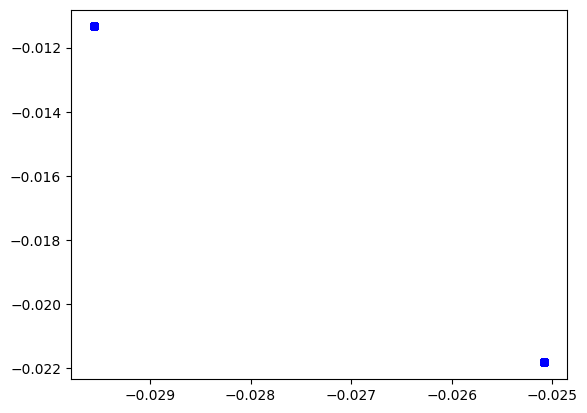

In [12]:
'''
Now we have users_embedding_Nx168 = Nx168 and movies_168xM = 168xM and
the sparse ratings matrix = NxM.
users_embedding_Nx168 * movies_168xM gives another matrix where for each user, we
have a relationship to a movie, but as it is now, doing the multiplication overflows
RAM (even on google collab), so cannot do the mult, but maybe this is still useful:
np.dot(users_embedding_Nx168[0], movies_168xM[0]) is a representation of user 0, w.r.t.
movie 0.

Meanwhile, lets try clustering the users. Lets plot the users on some random features, see if
anything is interesting.
'''
plt.scatter(users_embedding_Nx168[:, 0], users_embedding_Nx168[:, 1], s = 30, color ='b')

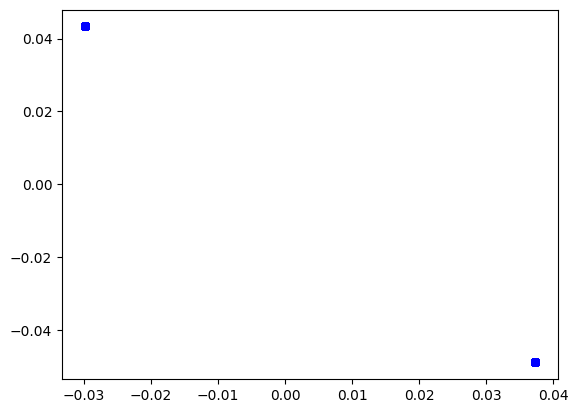

In [14]:
plt.scatter(users_embedding_Nx168[:, 12], users_embedding_Nx168[:, 13], s = 30, color ='b')

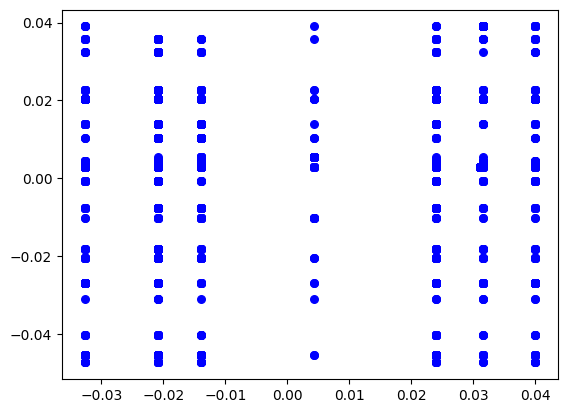

In [16]:
plt.scatter(users_embedding_Nx168[:, 55], users_embedding_Nx168[:, 100], s = 30, color ='b')
# not sure what this one means. Features 55 and 100 have no correlation?

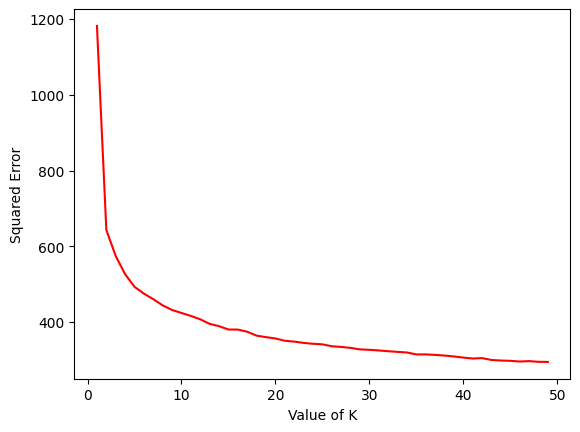

In [17]:
'''
Now let's try to find a good k to do kmeans clustering with by looking
at the errors using different ks. Takes about an hour to run with ks=50
'''
cost =[]
ks = 50
ks_range = range(1, 50)
for i in ks_range:
    kmeans_i = KMeans(n_clusters = i, max_iter = 500)
    kmeans_i.fit(users_embedding_Nx168)

    # store error for the clustered points
    cost.append(kmeans_i.inertia_)

# plot the cost against K values
plt.plot(ks_range, cost, color ='r')
plt.xlabel("Value of K")
plt.ylabel("Squared Error")
plt.show()

In [20]:
'''
Looks like a good k is in the "elbow" of this graph, so bout 5, 6
'''
K = 5
kmeans = KMeans(n_clusters=K, random_state=0).fit(users_embedding_Nx168)

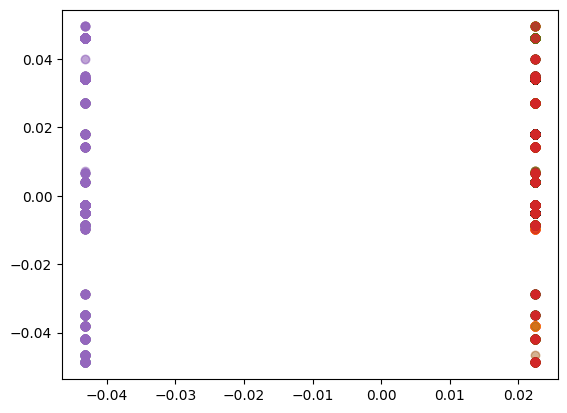

In [50]:
'''
Plotting the clusters, it is hard to know what features to use as the x and y
axis without doing some kind of eigenvalue decomp or pca, but the matrix is too big for that.
But found an okay one. This shows a seperation on these 2 dims of we think 4 on the right vs 1 on the left.
'''
plt.clf()
for i in range(K):
    filtered_i = users_embedding_Nx168[kmeans.labels_ == i]
    plt.scatter(filtered_i[:,10], filtered_i[:,125], label=i, alpha=0.2)

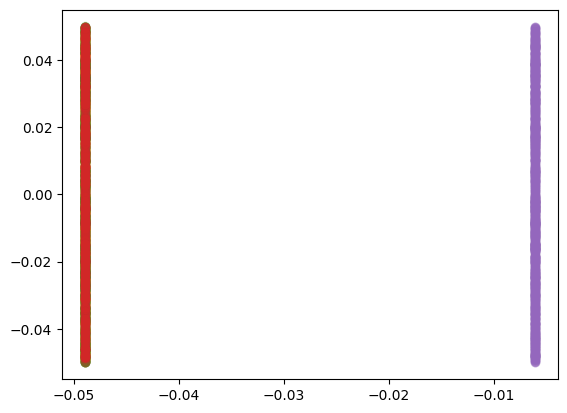

In [53]:
'''
This shows a seperation on these 2 dims of we think 4 on the left vs 1 on the right.
'''
plt.clf()
for i in range(K):
    filtered_i = users_embedding_Nx168[kmeans.labels_ == i]
    plt.scatter(filtered_i[:,0], filtered_i[:,users_embedding_Nx168.shape[1]-1], label=i, alpha=0.2)

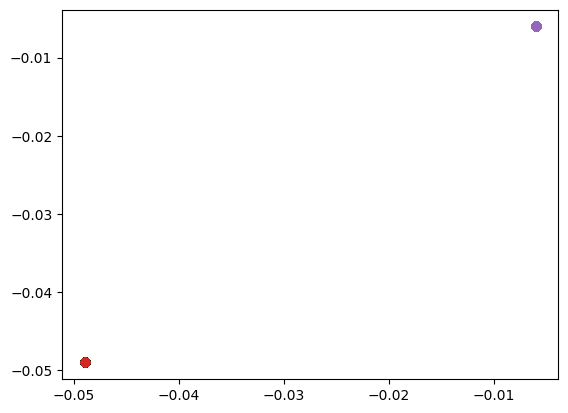

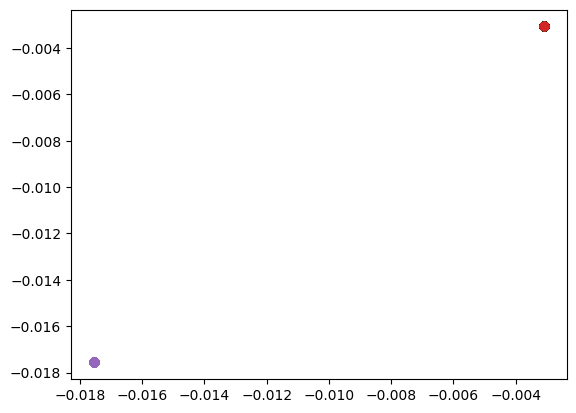

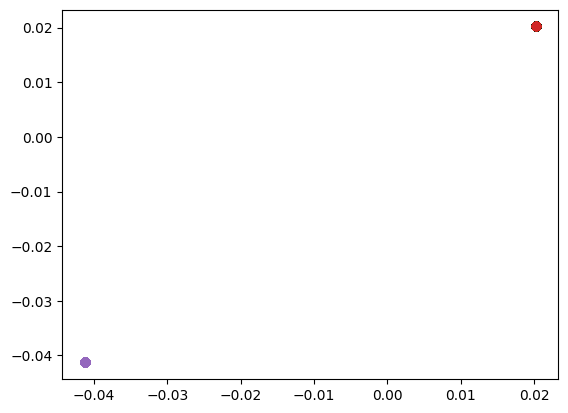

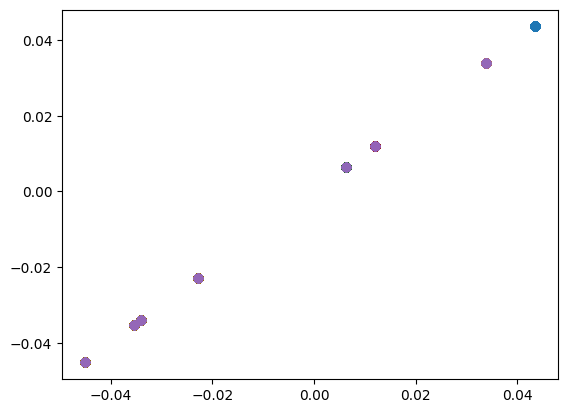

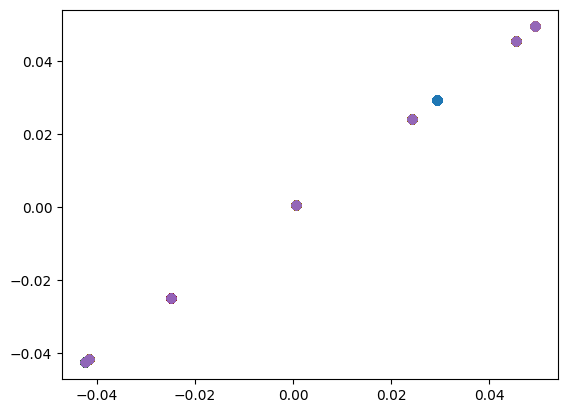

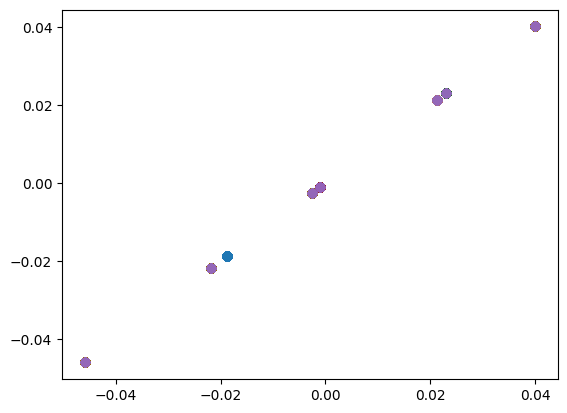

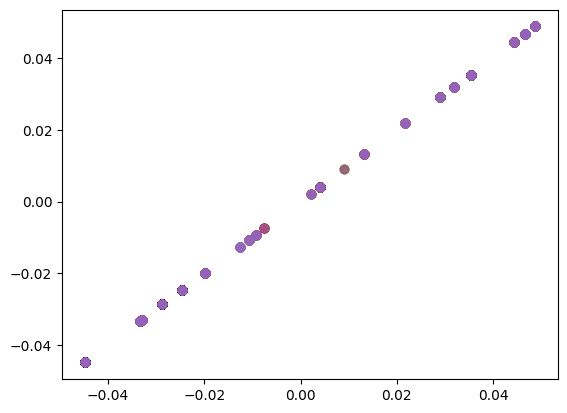

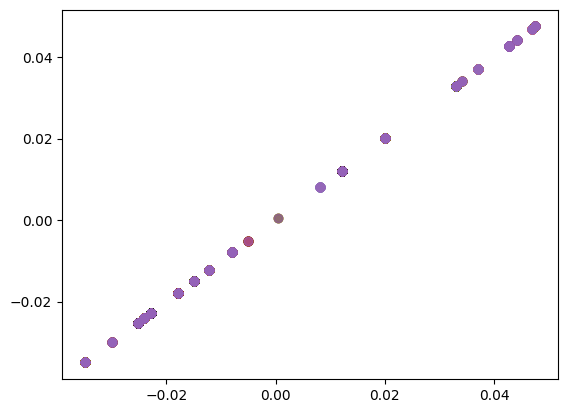

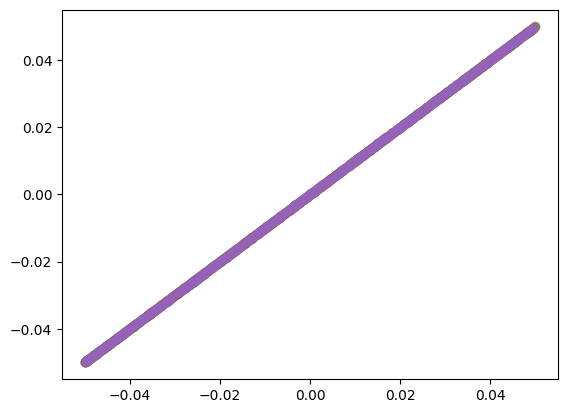

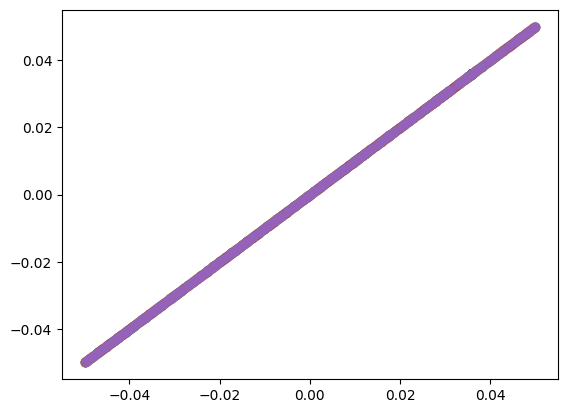

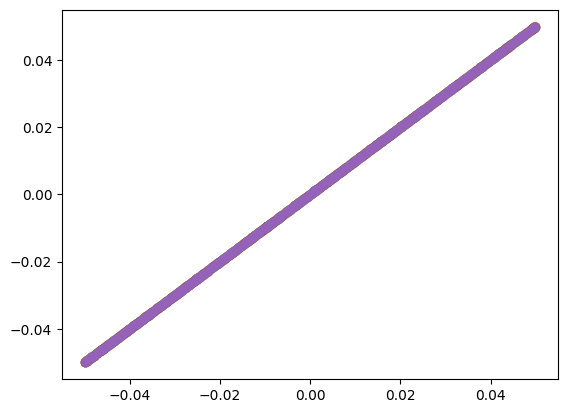

In [63]:
'''
Can use the same feature as both dims and see how the clustering is w.r.t. that feature.
'''
for f in range(0, users_embedding_Nx168.shape[1], 16):
    plt.clf()
    for i in range(K):
        filtered_i = users_embedding_Nx168[kmeans.labels_ == i]
        plt.scatter(filtered_i[:,f], filtered_i[:,f], label=i, alpha=0.2)
    plt.show()

In [ ]:
'''
Save this model for use later during classification
'''
pickle.dump(kmeans, open(PATH_TO_USER_KMEANS_MODEL, "wb"))

In [26]:
'''
Make a consine similarity upper triangular matrix for use in classification later.

Goal is to get the cosine sims. If we get the cosine sims of each movie to each movie, we will have
an upper triangular matrix, that if reflected along the diagonal, will make a symetric,
square, weighted matrix of how realted each movie is to one another.

However, problem is it is just too big, so gonna have to sorta use the disk as part of the cache,
breaking the matrix into some number of smaller matrices, saving each one to the disk,
then when checking similairity of movies later, read a matrix, use it, dispose it,
read another, dispose it, etc.
This takes about a 2 hours to run on 4 cpus.
'''
partitions = 18
rows_per_partition = int(total_movies/partitions)
sim_mat_paths = []
# the last partition will have those rows that don't divide in evenly
for p in range(partitions-1):
    partition_start = p*rows_per_partition
    sim_mat_paths.append(write_partition(
        partition_start,
        partition_start+rows_per_partition,
        non_title_std_procd_movies))

# get the last partition, it having a few extra rows
num_extra_rows = total_movies%(rows_per_partition*partitions)
partition_start = (partitions-1)*rows_per_partition
sim_mat_paths.append(write_partition(
        partition_start,
        partition_start+rows_per_partition+num_extra_rows,
        non_title_std_procd_movies)) 

In [ ]:
'''
Save the partitioning meta data
'''
with open(PATH_TO_COSINE_SIMS_PARTITION_SPECS, "w") as out_file:
    out_file.write(
        json.dumps(
            {
                SPEC_PARTITIONS: str(partitions),
                SPEC_PARTITION_PATHS: sim_mat_paths,
                SPEC_ROWS_PER_PARTITION: str(rows_per_partition),
                SPEC_EXTRA_ROWS_IN_LAST_PARTITION: str(num_extra_rows)
            },
            indent=4))